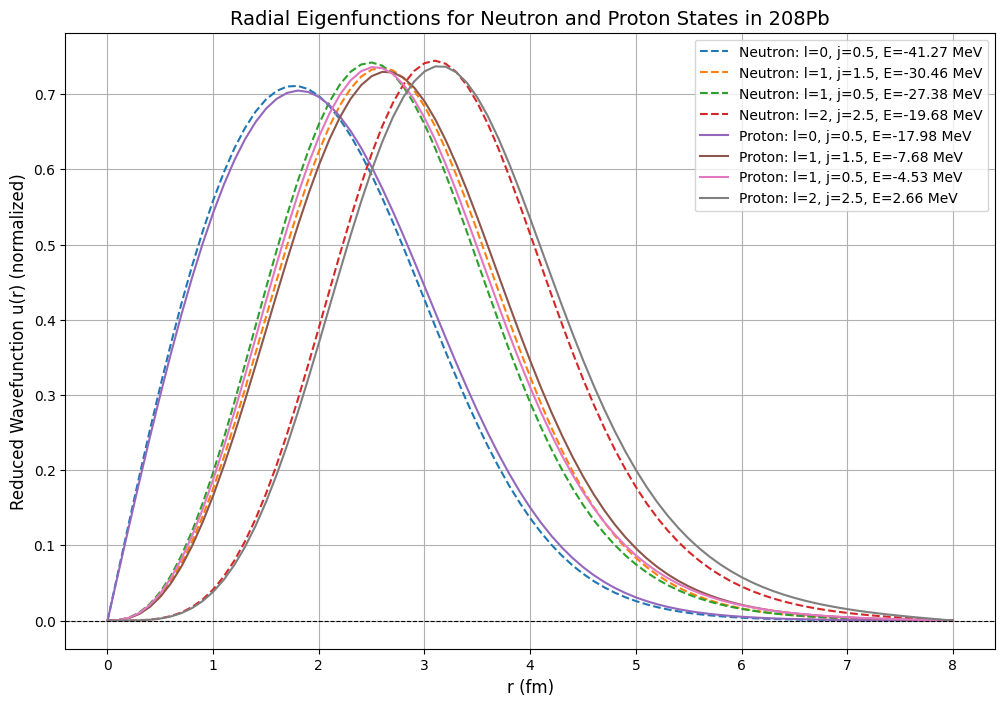

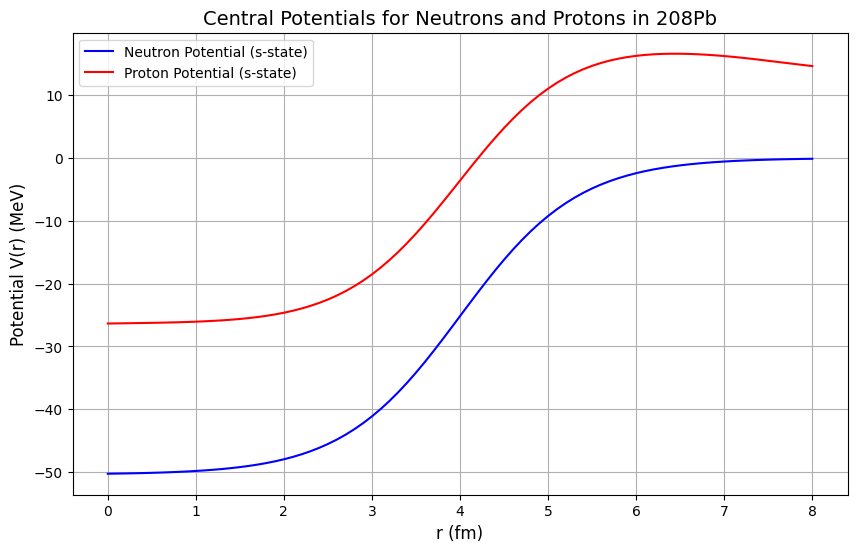

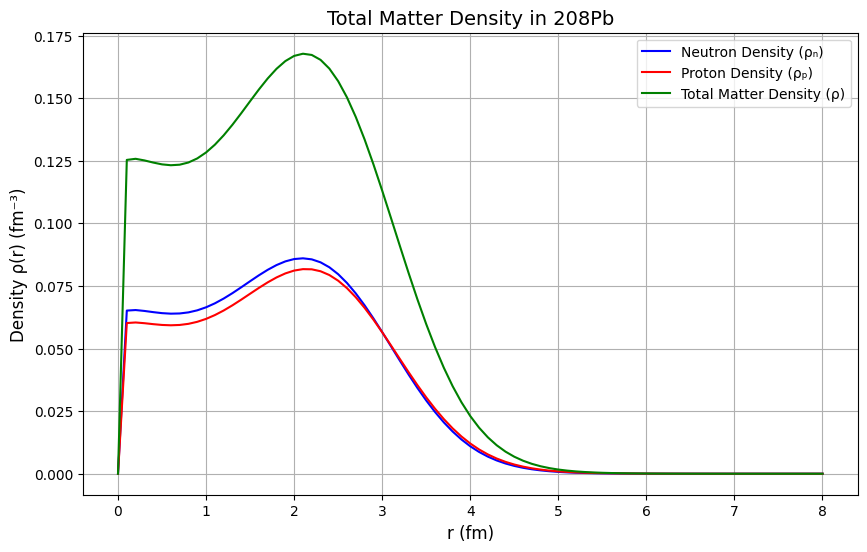

Neutron Eigenvalues (MeV):
l=0, j=0.5: E=-41.27 MeV
l=1, j=1.5: E=-30.46 MeV
l=1, j=0.5: E=-27.38 MeV
l=2, j=2.5: E=-19.68 MeV

Proton Eigenvalues (MeV):
l=0, j=0.5: E=-17.98 MeV
l=1, j=1.5: E=-7.68 MeV
l=1, j=0.5: E=-4.53 MeV
l=2, j=2.5: E=2.66 MeV


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Constants and Parameters
# -----------------------------
hbar2_over_2m = 20.75  # MeV·fm²
V0 = 50.4            # MeV (central potential depth for neutrons in 208Pb)
R = 4.0              # fm (radius of the Wood–Saxon potential)
a = 0.67             # fm (diffuseness parameter)
r0 = 1.27            # fm
V_ls = 0.44 * V0     # Spin–orbit coupling strength
h = 0.1              # fm (mesh size)
tolerance = 1e-6     # Energy convergence criterion

# Proton-specific parameters
Z = 82               # Proton number
e2 = 1.44            # MeV·fm (electric charge squared)
Rc = 1.25 * (208**(1/3))  # fm (charge radius)

# -----------------------------
# Potentials
# -----------------------------
def V_ws(r):
    """Wood–Saxon potential."""
    return -V0 / (1 + np.exp((r - R) / a))

def V_so(r):
    """Spin–orbit potential (guarded for r=0)."""
    if r <= 0:
        return 0.0
    df_dr = -(1 / a) * np.exp((r - R) / a) / (1 + np.exp((r - R) / a))**2
    return V_ls * r0**2 / r * df_dr

def V_coulomb(r):
    """Coulomb potential for protons."""
    if r <= Rc:
        return (Z * e2) / (2 * Rc) * (3 - (r / Rc)**2)
    else:
        return (Z * e2) / r

def V_total_neutron(r, l, j):
    """Total central potential for neutrons: WS + spin–orbit."""
    l_dot_s = 0.5 * (j*(j+1) - l*(l+1) - 0.75)
    V_spin_orbit = V_so(r) * l_dot_s if r > 0 else 0.0
    return V_ws(r) + V_spin_orbit

def V_total_proton(r, l, j):
    """Total central potential for protons: WS + spin–orbit + Coulomb."""
    l_dot_s = 0.5 * (j*(j+1) - l*(l+1) - 0.75)
    V_spin_orbit = V_so(r) * l_dot_s if r > 0 else 0.0
    return V_ws(r) + V_spin_orbit + V_coulomb(r)

# -----------------------------
# Numerov Method for Reduced Radial Wavefunction u(r) = r R(r)
# -----------------------------
def numerov(E, x_grid, l, j, V_func):
    """
    Solve the radial Schrödinger equation for the reduced wavefunction u(r)=rR(r)
    using Numerov's method. The effective potential is
      V_eff(r) = V_total(r, l, j) + l(l+1)*(hbar2_over_2m)/r^2.
    The near-origin behavior u(r) ~ r^(l+1) is enforced:
         u(0)=0,  u(h)=h^(l+1).
    """
    N = len(x_grid)
    u = np.zeros(N)
    # Build effective potential with centrifugal term:
    V_eff = np.array([V_func(r, l, j) + (l*(l+1)*hbar2_over_2m)/(r**2) if r > 0 else 0.0
                       for r in x_grid])
    # Define k(r) = 2*(E - V_eff)/ (hbar2_over_2m)
    k = 2 * (E - V_eff) / hbar2_over_2m

    # Set boundary conditions: u(0)=0, u(h)=h^(l+1)
    u[0] = 0.0
    u[1] = h**(l+1)

    for i in range(1, N-1):
        u[i+1] = ((2 * (1 - (5*h**2/12)*k[i]) * u[i]
                   - (1 + (h**2/12)*k[i-1]) * u[i-1])
                  / (1 + (h**2/12)*k[i+1]))
    return u

# -----------------------------
# Shooting Method to Find Eigenvalues
# -----------------------------
def shooting_method(n_nodes, x_grid, l, j, V_func):
    E_low, E_high = -V0, 100.0  # Set an energy search range
    u = None
    while E_high - E_low > tolerance:
        E_mid = (E_low + E_high) / 2
        u = numerov(E_mid, x_grid, l, j, V_func)
        # Count nodes (zero crossings beyond the origin)
        nodes = np.sum(u[1:] * u[:-1] < 0)
        if nodes > n_nodes:
            E_high = E_mid
        else:
            E_low = E_mid
    return E_mid, u

# -----------------------------
# Spatial Grid
# -----------------------------
# Start slightly above r=0 to avoid singularity.
x_grid = np.arange(0.001, 2 * R + h, h)

# -----------------------------
# Solve for Eigenstates (Neutrons and Protons)
# -----------------------------
# We choose states such that the ground state is the s1/2 (l=0, j=0.5) state.
states = [(0, 0.5), (1, 1.5), (1, 0.5), (2, 2.5)]
neutron_results = []
proton_results = []

for l, j in states:
    E_n, u_n = shooting_method(0, x_grid, l, j, V_total_neutron)
    norm_n = np.sqrt(np.sum(u_n**2)*h)
    neutron_results.append((l, j, E_n, u_n / norm_n))

    E_p, u_p = shooting_method(0, x_grid, l, j, V_total_proton)
    norm_p = np.sqrt(np.sum(u_p**2)*h)
    proton_results.append((l, j, E_p, u_p / norm_p))

# -----------------------------
# Plotting: Radial Eigenfunctions
# -----------------------------
plt.figure(figsize=(12,8))
# Plot neutron eigenfunctions
for l, j, E, u in neutron_results:
    plt.plot(x_grid, u, label=f"Neutron: l={l}, j={j}, E={E:.2f} MeV", linestyle="--")
# Plot proton eigenfunctions
for l, j, E, u in proton_results:
    plt.plot(x_grid, u, label=f"Proton: l={l}, j={j}, E={E:.2f} MeV")
plt.title("Radial Eigenfunctions for Neutron and Proton States in 208Pb", fontsize=14)
plt.xlabel("r (fm)", fontsize=12)
plt.ylabel("Reduced Wavefunction u(r) (normalized)", fontsize=12)
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.legend()
plt.grid()
plt.show()

# -----------------------------
# Plotting: Central Potentials for the s-state (l=0, j=0.5)
# -----------------------------
V_neutron = [V_total_neutron(r, 0, 0.5) for r in x_grid]
V_proton = [V_total_proton(r, 0, 0.5) for r in x_grid]

plt.figure(figsize=(10,6))
plt.plot(x_grid, V_neutron, label="Neutron Potential (s-state)", color="blue")
plt.plot(x_grid, V_proton, label="Proton Potential (s-state)", color="red")
plt.title("Central Potentials for Neutrons and Protons in 208Pb", fontsize=14)
plt.xlabel("r (fm)", fontsize=12)
plt.ylabel("Potential V(r) (MeV)", fontsize=12)
plt.legend()
plt.grid()
plt.show()

# -----------------------------
# Matter Density Calculation
# -----------------------------
def density_equation(results, x_grid):
    """
    Calculate matter density from a set of states.
    For each state, using the reduced wavefunction u(r), the radial density is |R(r)|² = u(r)² / r².
    Multiply by the degeneracy factor g = 2j+1 and divide by 4π.
    """
    rho = np.zeros_like(x_grid)
    for l, j, E, u in results:
        g = 2 * j + 1  # degeneracy
        rho += g * (u**2) / (4 * np.pi * x_grid**2)
    return rho

rho_neutron = density_equation(neutron_results, x_grid)
rho_proton = density_equation(proton_results, x_grid)
rho_total = rho_neutron + rho_proton

plt.figure(figsize=(10,6))
plt.plot(x_grid, rho_neutron, label="Neutron Density (ρₙ)", color="blue")
plt.plot(x_grid, rho_proton, label="Proton Density (ρₚ)", color="red")
plt.plot(x_grid, rho_total, label="Total Matter Density (ρ)", color="green")
plt.title("Total Matter Density in 208Pb", fontsize=14)
plt.xlabel("r (fm)", fontsize=12)
plt.ylabel("Density ρ(r) (fm⁻³)", fontsize=12)
plt.legend()
plt.grid()
plt.show()

# -----------------------------
# Print Eigenvalues
# -----------------------------
print("Neutron Eigenvalues (MeV):")
for l, j, E, _ in neutron_results:
    print(f"l={l}, j={j}: E={E:.2f} MeV")

print("\nProton Eigenvalues (MeV):")
for l, j, E, _ in proton_results:
    print(f"l={l}, j={j}: E={E:.2f} MeV")


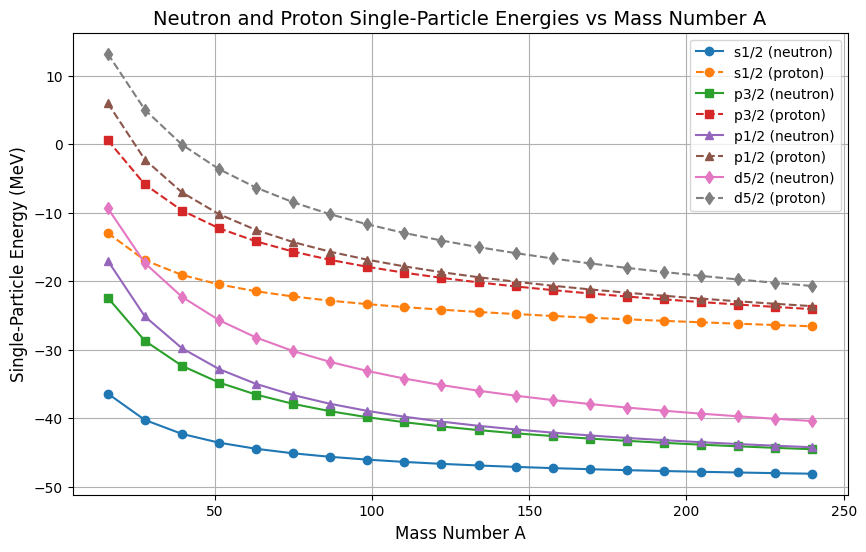

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq

# -----------------------------
# Global Constants and Parameters
# -----------------------------
hbar2_over_2m = 20.75   # MeV·fm²
V0 = 50.4             # MeV (central potential depth)
a = 0.67              # fm (diffuseness parameter)
V_ls = 0.44 * V0      # Spin–orbit coupling strength
r0_spin = 1.27        # fm (for spin–orbit)
r0_nucleus = 1.25     # fm (for nuclear radius)
h = 0.1               # fm (mesh size)
tolerance = 1e-6      # Energy convergence tolerance

# -----------------------------
# Potentials with explicit R dependence
# -----------------------------
def V_ws(r, R_val):
    """Wood–Saxon potential with radius R_val."""
    return -V0 / (1 + np.exp((r - R_val)/a))

def V_so(r, R_val):
    """Spin–orbit potential with radius parameter R_val. Guard against r=0."""
    if r <= 0:
        return 0.0
    df_dr = -(1/a) * np.exp((r - R_val)/a) / (1 + np.exp((r - R_val)/a))**2
    return V_ls * r0_spin**2 / r * df_dr

def V_coulomb(r, Z=82, Rc=None):
    """Coulomb potential for protons."""
    if r <= Rc:
        return (Z * 1.44)/(2 * Rc) * (3 - (r/Rc)**2)
    else:
        return (Z * 1.44)/r

def V_total_neutron(r, l, j, R_val):
    """Total central potential for neutrons (WS + spin–orbit) with radius R_val."""
    l_dot_s = 0.5*(j*(j+1) - l*(l+1) - 0.75)
    V_spin_orbit = V_so(r, R_val)*l_dot_s if r > 0 else 0.0
    return V_ws(r, R_val) + V_spin_orbit

def V_total_proton(r, l, j, R_val):
    """Total central potential for protons (WS + spin–orbit + Coulomb) with radius R_val."""
    l_dot_s = 0.5*(j*(j+1) - l*(l+1) - 0.75)
    V_spin_orbit = V_so(r, R_val)*l_dot_s if r > 0 else 0.0
    # For simplicity, we use a fixed charge radius for 208Pb
    Rc = 1.25 * (208**(1/3))
    return V_ws(r, R_val) + V_spin_orbit + V_coulomb(r, Z=82, Rc=Rc)

# -----------------------------
# Numerov Method for Reduced Radial Wavefunction u(r)=rR(r)
# -----------------------------
def numerov(E, x_grid, l, j, V_func, R_val):
    """
    Solve the radial Schrödinger equation for the reduced wavefunction u(r)=rR(r)
    using Numerov's method.

    The effective potential is:
        V_eff(r) = V_total(r, l, j; R_val) + l(l+1)*(hbar2_over_2m)/r².
    Boundary conditions are set as:
        u(0) = 0,   u(h) = h^(l+1)
    """
    N = len(x_grid)
    u = np.zeros(N)
    # Build effective potential with centrifugal term:
    V_eff = np.array([V_func(r, l, j, R_val) + (l*(l+1)*hbar2_over_2m)/(r**2) if r>0 else 0.0
                       for r in x_grid])
    k = 2 * (E - V_eff) / hbar2_over_2m

    u[0] = 0.0
    u[1] = h**(l+1)

    for i in range(1, N-1):
        u[i+1] = ((2 * (1 - (5*h**2/12)*k[i])*u[i] - (1 + (h**2/12)*k[i-1])*u[i-1])
                  / (1 + (h**2/12)*k[i+1]))
    return u

# -----------------------------
# Shooting Method (node counting)
# -----------------------------
def shooting_method(n_nodes, x_grid, l, j, V_func, R_val):
    E_low, E_high = -V0, 100.0
    while E_high - E_low > tolerance:
        E_mid = (E_low + E_high) / 2
        u = numerov(E_mid, x_grid, l, j, V_func, R_val)
        nodes = np.sum(u[1:]*u[:-1] < 0)
        if nodes > n_nodes:
            E_high = E_mid
        else:
            E_low = E_mid
    return (E_low+E_high)/2, u

# -----------------------------
# Orbitals to Track: (l,j) for selected single-particle orbits.
# Here we choose:
#   s1/2: (0, 0.5)
#   p3/2: (1, 1.5)
#   p1/2: (1, 0.5)
#   d5/2: (2, 2.5)
# -----------------------------
states = { "s1/2": (0, 0.5),
           "p3/2": (1, 1.5),
           "p1/2": (1, 0.5),
           "d5/2": (2, 2.5) }

# -----------------------------
# Loop over Mass Number A and Compute Eigenvalues
# -----------------------------
A_values = np.linspace(16, 240, 20)   # from light to heavy nuclei
orbit_energies_neutron = { key: [] for key in states.keys() }
orbit_energies_proton = { key: [] for key in states.keys() }

for A in A_values:
    R_val = r0_nucleus * A**(1/3)
    # Spatial grid from small r to ~2*R_val:
    x_grid = np.arange(0.001, 2*R_val + h, h)
    for orb, (l, j) in states.items():
        E_n, u_n = shooting_method(0, x_grid, l, j, V_total_neutron, R_val)
        orbit_energies_neutron[orb].append(E_n)
        E_p, u_p = shooting_method(0, x_grid, l, j, V_total_proton, R_val)
        orbit_energies_proton[orb].append(E_p)

# -----------------------------
# Plot: Neutron and Proton Orbits vs Mass Number A
# -----------------------------
plt.figure(figsize=(10,6))
markers = {"s1/2": "o", "p3/2": "s", "p1/2": "^", "d5/2": "d"}
for orb in states.keys():
    plt.plot(A_values, orbit_energies_neutron[orb], marker=markers[orb],
             linestyle='-', label=f"{orb} (neutron)")
    plt.plot(A_values, orbit_energies_proton[orb], marker=markers[orb],
             linestyle='--', label=f"{orb} (proton)")
plt.xlabel("Mass Number A", fontsize=12)
plt.ylabel("Single-Particle Energy (MeV)", fontsize=12)
plt.title("Neutron and Proton Single-Particle Energies vs Mass Number A", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()
